In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/SDH_UIT/Stage_3/AdvancedBAAnalytics/Final

/content/drive/.shortcut-targets-by-id/1j2AsRwZLOtXWAKowz2dDMvlnI3TGpJkp/SDH_UIT/Stage_3/AdvancedBAAnalytics/Final


# Engry

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score

In [40]:
# Compute PRR
def compute_prr(y_true, y_mean, y_std):
    y_true, y_mean, y_std = np.array(y_true), np.array(y_mean), np.array(y_std)
    sorted_idx = np.argsort(-y_std)  # giảm dần theo độ bất định
    mse_full = np.mean((y_true - y_mean) ** 2)
    prr_values = []
    for reject_frac in np.linspace(0, 0.9, 10):
        keep_n = int((1 - reject_frac) * len(y_true))
        idx_keep = sorted_idx[:keep_n]
        mse_reduced = np.mean((y_true[idx_keep] - y_mean[idx_keep]) ** 2)
        prr = mse_full / mse_reduced if mse_reduced > 0 else 1.0
        prr_values.append(prr)
    slope = prr_values[-1] - prr_values[0]
    return slope, prr_values

# Vẽ PRR Curve
def plot_prr_curve(prr_curve, title):
    plt.figure(figsize=(6, 4))
    plt.plot(np.linspace(0, 0.9, len(prr_curve)), prr_curve, marker='o', label="PRR Curve")
    plt.xlabel("Rejection Rate")
    plt.ylabel("Prediction-Rejection Ratio")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Vẽ Histogram độ bất định
def plot_uncertainty_histogram(std_in, std_ood, title):
    plt.figure(figsize=(6, 4))
    plt.hist(std_in, bins=30, alpha=0.7, label="In-Distribution", color="green")
    plt.hist(std_ood, bins=30, alpha=0.7, label="OOD", color="red")
    plt.xlabel("Predictive Std (Uncertainty)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [41]:
# Load dữ liệu
energy_train = pd.read_csv('data/energy.csv')  # gồm X1–X8, Y1, Y2
energy_ood = pd.read_csv('data/OOD-energy.txt', header=None, sep='\s+')

# Chọn nhãn Y1
X_train_energy = energy_train.iloc[:, :8]
y_train_energy = energy_train['Y1']

# Scale
scaler_energy = StandardScaler()
X_train_scaled = scaler_energy.fit_transform(X_train_energy)
X_ood_scaled = scaler_energy.transform(energy_ood)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [42]:
# Huấn luyện nhiều mô hình (SGLB style)
n_models = 10
preds_train, preds_ood = [], []

for seed in range(n_models):
    model = GradientBoostingRegressor(
        n_estimators=50, learning_rate=0.03, max_depth=6,
        subsample=0.9, random_state=seed
    )
    model.fit(X_train_scaled, y_train_energy)
    preds_train.append(model.predict(X_train_scaled))
    preds_ood.append(model.predict(X_ood_scaled))

In [43]:
# Trung bình và độ lệch chuẩn
y_pred_mean = np.mean(preds_train, axis=0)
y_pred_std = np.std(preds_train, axis=0)
ood_pred_mean = np.mean(preds_ood, axis=0)
ood_pred_std = np.std(preds_ood, axis=0)

# Đánh giá
rmse = np.sqrt(mean_squared_error(y_train_energy, y_pred_mean))
prr_score, prr_curve = compute_prr(y_train_energy, y_pred_mean, y_pred_std)
labels = np.concatenate([np.zeros(len(y_pred_mean)), np.ones(len(ood_pred_mean))])
scores = np.concatenate([y_pred_std, ood_pred_std])
auc = roc_auc_score(labels, scores)

In [44]:
print("🔋 ENERGY DATASET")
print(f"RMSE: {rmse:.4f}")
print(f"PRR: {prr_score:.4f}")
print(f"AUC-ROC (OOD): {auc:.4f}")

🔋 ENERGY DATASET
RMSE: 2.2392
PRR: 0.3930
AUC-ROC (OOD): 1.0000


In [45]:
prr_curve

[np.float64(1.0),
 np.float64(1.01066519895858),
 np.float64(0.975270112333591),
 np.float64(0.9468612717910293),
 np.float64(0.9132532764723941),
 np.float64(0.9448216557720358),
 np.float64(0.9327995175011842),
 np.float64(0.9457245386164477),
 np.float64(0.8653780196246685),
 np.float64(1.3930280220363784)]

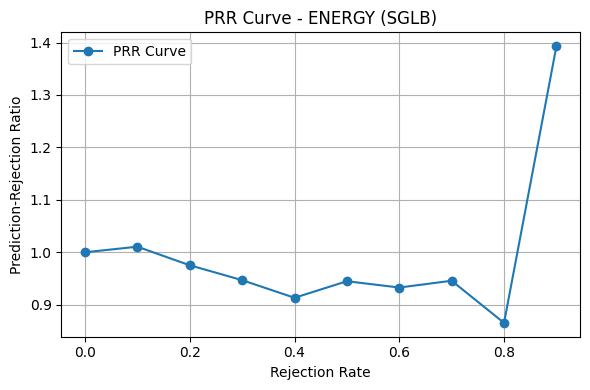

In [46]:
# Biểu đồ
plot_prr_curve(prr_curve, title="PRR Curve - ENERGY (SGLB)")

In [47]:
y_pred_std

array([0.01741847, 0.01741847, 0.02068946, 0.00894425, 0.0187813 ,
       0.0187813 , 0.02328084, 0.02843989, 0.02554325, 0.02554325,
       0.0189986 , 0.02017603, 0.03562027, 0.03562027, 0.03131246,
       0.03001747, 0.00964846, 0.01401254, 0.01407506, 0.00757815,
       0.02436817, 0.02304529, 0.02198345, 0.01937861, 0.00060161,
       0.00060161, 0.00060161, 0.00060161, 0.00051788, 0.00051788,
       0.00051788, 0.00051788, 0.00116139, 0.00116139, 0.00116139,
       0.00116139, 0.00068875, 0.00068875, 0.00068875, 0.00068875,
       0.00724239, 0.00571388, 0.00501709, 0.005384  , 0.00205292,
       0.00132799, 0.00052884, 0.00147913, 0.01196574, 0.01196574,
       0.01196574, 0.01196574, 0.01300887, 0.01300887, 0.01300887,
       0.01300887, 0.0194201 , 0.0194201 , 0.0194201 , 0.0194201 ,
       0.01717184, 0.01850052, 0.02005176, 0.0237109 , 0.02671181,
       0.02382735, 0.01985851, 0.02042075, 0.0139705 , 0.01072281,
       0.01186898, 0.01637123, 0.00301058, 0.00301058, 0.00324

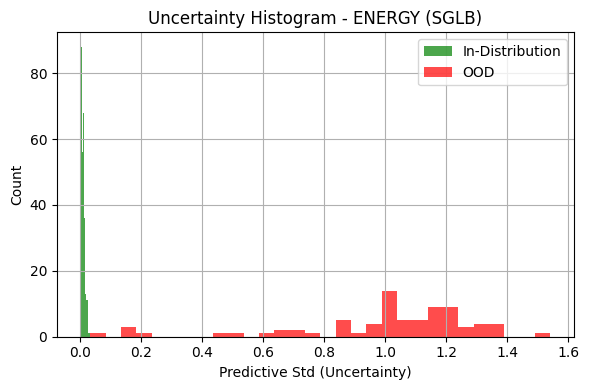

In [48]:
plot_uncertainty_histogram(y_pred_std, ood_pred_std, title="Uncertainty Histogram - ENERGY (SGLB)")

# Naval

In [49]:
# Load dữ liệu
naval_train = pd.read_csv("data/naval.csv", header=None, sep='\s+')
naval_ood = pd.read_csv("data/OOD-naval.txt", header=None, sep='\s+')

# Dữ liệu: 16 đặc trưng đầu, cột 16 (index 16) là nhãn (theo chuẩn benchmark)
X_train_naval = naval_train.iloc[:, :16]
y_train_naval = naval_train.iloc[:, 16]

# Scale
scaler_naval = StandardScaler()
X_train_naval_scaled = scaler_naval.fit_transform(X_train_naval)
X_ood_naval_scaled = scaler_naval.transform(naval_ood.iloc[:, :16])

In [50]:
# Huấn luyện nhiều mô hình
preds_train, preds_ood = [], []

for seed in range(n_models):
    model = GradientBoostingRegressor(
        n_estimators=50, learning_rate=0.03, max_depth=6,
        subsample=0.9, random_state=seed
    )
    model.fit(X_train_naval_scaled, y_train_naval)
    preds_train.append(model.predict(X_train_naval_scaled))
    preds_ood.append(model.predict(X_ood_naval_scaled))


In [51]:
# Trung bình và độ lệch chuẩn
y_pred_mean = np.mean(preds_train, axis=0)
y_pred_std = np.std(preds_train, axis=0)
ood_pred_mean = np.mean(preds_ood, axis=0)
ood_pred_std = np.std(preds_ood, axis=0)

# Đánh giá
rmse = np.sqrt(mean_squared_error(y_train_naval, y_pred_mean))
prr_score, prr_curve = compute_prr(y_train_naval, y_pred_mean, y_pred_std)
labels = np.concatenate([np.zeros(len(y_pred_mean)), np.ones(len(ood_pred_mean))])
scores = np.concatenate([y_pred_std, ood_pred_std])
auc = roc_auc_score(labels, scores)

print("\n🚢 NAVAL DATASET")
print(f"RMSE: {rmse:.4f}")
print(f"PRR: {prr_score:.4f}")
print(f"AUC-ROC (OOD): {auc:.4f}")


🚢 NAVAL DATASET
RMSE: 0.0075
PRR: 0.2292
AUC-ROC (OOD): 0.8615


In [52]:
prr_curve

[np.float64(1.0),
 np.float64(0.9517917440323266),
 np.float64(0.9144584797028015),
 np.float64(0.9073050840889144),
 np.float64(0.9652470538762964),
 np.float64(1.013939319522014),
 np.float64(1.0748537771919946),
 np.float64(1.094338302213113),
 np.float64(1.1689574789077912),
 np.float64(1.2292434335778861)]

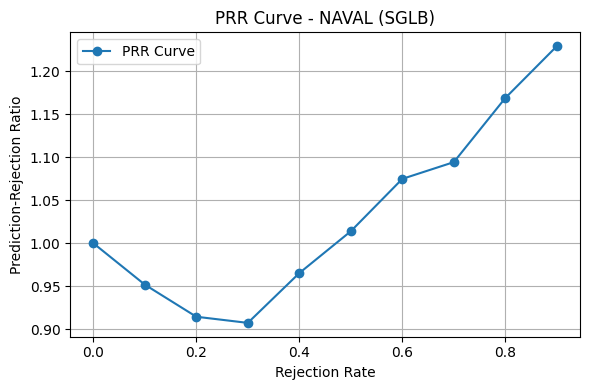

In [53]:
plot_prr_curve(prr_curve, title="PRR Curve - NAVAL (SGLB)")

In [62]:
print(len(y_pred_std))

11934


In [64]:
y_pred_std[:1000]

array([4.77242587e-04, 2.59655626e-04, 1.83731389e-04, 1.92036257e-04,
       1.70801674e-04, 1.30866417e-04, 1.80429903e-04, 2.56775587e-04,
       1.80229045e-04, 4.22835594e-04, 2.22331551e-04, 1.83731389e-04,
       2.16139859e-04, 1.70801674e-04, 1.30866417e-04, 1.80429903e-04,
       2.61274290e-04, 1.63421176e-04, 2.02192212e-04, 2.22331551e-04,
       1.83731389e-04, 2.16139859e-04, 1.70801674e-04, 1.30866417e-04,
       1.80429903e-04, 2.61274290e-04, 1.76464232e-04, 4.99594074e-04,
       2.22331551e-04, 1.83731389e-04, 2.16139859e-04, 1.70801674e-04,
       9.53185042e-05, 1.80429903e-04, 2.61274290e-04, 1.72876965e-04,
       3.05839175e-04, 2.28992369e-04, 1.83731389e-04, 2.16139859e-04,
       1.70801674e-04, 9.53185042e-05, 1.80429903e-04, 2.61274290e-04,
       1.67033922e-04, 1.77616719e-04, 2.28992369e-04, 1.83731389e-04,
       2.41145128e-04, 1.70801674e-04, 9.53185042e-05, 1.80429903e-04,
       2.61274290e-04, 1.63950649e-04, 1.77616719e-04, 2.08075044e-04,
      

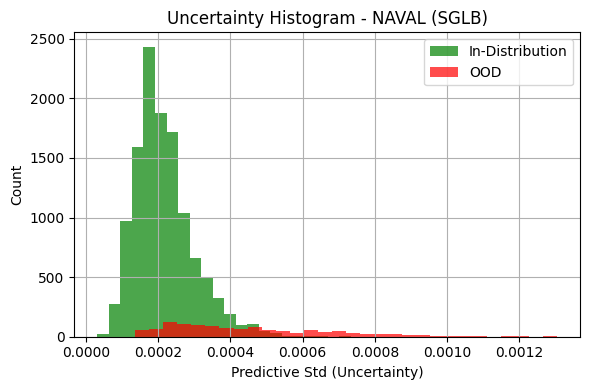

In [55]:
plot_uncertainty_histogram(y_pred_std, ood_pred_std, title="Uncertainty Histogram - NAVAL (SGLB)")